# Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import Transfer, mape

# Loading datasets

In [2]:
# French data
train = pd.read_csv('data/train.csv')
test1 = pd.read_csv('data/test1.csv')
test2 = pd.read_csv('data/test2.csv')
test3 = pd.read_csv('data/test3.csv')

# Italian data
train_it = pd.read_csv('data/train_it.csv')
test1_it = pd.read_csv('data/test1_it.csv')
test2_it = pd.read_csv('data/test2_it.csv')


In [3]:
# Scale parameter, instead of summing over a year we just take the mean
# rho = train["Consommation"].mean()/train_it["Consommation"].mean()
# rho = None

In [4]:
train_it_2018 = train_it.query("DateH >='2018-01-01 02:00:00' and DateH <='2019-01-01 01:00:00'")
train_fr_2018 = train.query("DateH >='2018-01-01 02:00:00' and DateH <='2019-01-01 01:00:00'")
rho = train_fr_2018["Consommation"].sum()/train_it_2018["Consommation"].sum()
rho

2.9575085066167826

In [5]:
# value not to use
test1["Consommation"].sum()/test1_it["Consommation"].sum()

3.450460824000352

# Loading experts

### Forecasts

In [6]:
# French data
gamtrain = pd.read_csv('data/experts/gamtrain_forecast.csv')['x']
gam1 = pd.read_csv('data/experts/gam1_forecast.csv')['x']
gam2 = pd.read_csv('data/experts/gam2_forecast.csv')['x']
gbm1 = pd.read_csv('data/experts/gbm1_forecast.csv')['x']
gbm2 = pd.read_csv('data/experts/gbm2_forecast.csv')['x']

# Aggregation of experts
exp1 = pd.read_csv('data/experts/X1_agg.csv')['X1_agg']
exp2 = pd.read_csv('data/experts/X2_agg.csv')['X2_agg']

# Italian data
gamittrain = pd.read_csv('data/experts/gamit_forecast.csv')['x']
gam1_it = pd.read_csv('data/experts/gam1it_forecast.csv')['x']
gam2_it = pd.read_csv('data/experts/gam2it_forecast.csv')['x']
gbm1_it = pd.read_csv('data/experts/gbm1it_forecast.csv')['x']
gbm2_it = pd.read_csv('data/experts/gbm2it_forecast.csv')['x']


### Spline

In [7]:
# French data
basis = pd.read_csv('data/experts/basis_france.csv', index_col=0)
basis1 = pd.read_csv('data/experts/basis1_france.csv', index_col=0)
basis2 = pd.read_csv('data/experts/basis2_france.csv', index_col=0)
betas = pd.read_csv('data/experts/betas_france.csv', index_col=0)

# Italian data
basis_it = pd.read_csv('data/experts/basis_it.csv', index_col=0)
basis1_it = pd.read_csv('data/experts/basis1_it.csv', index_col=0)
basis2_it = pd.read_csv('data/experts/basis2_it.csv', index_col=0)
betas_it = pd.read_csv('data/experts/betas_it.csv', index_col=0)


# Fine tuning

### Test 1

In [8]:
tr_te1 = Transfer(betas, betas_it, basis1, basis1_it, test1['Consommation'], test1_it['Consommation'], K=75, rho=rho)
ft_te1 = tr_te1.gam_ft()

100%|██████████| 1488/1488 [00:29<00:00, 50.28it/s]


### Test 2

In [9]:
tr_te2 = Transfer(betas, betas_it, basis2, basis2_it, test2['Consommation'], test2_it['Consommation'], K=75,rho=rho)
ft_te2 = tr_te2.gam_ft()

100%|██████████| 2544/2544 [00:58<00:00, 43.14it/s]


# Transfer learning

## Test 1

In [10]:
tr_te1 = Transfer(betas, betas_it, basis1, basis1_it, test1['Consommation'], test1_it['Consommation'], K=75, rho=rho)
delta1 = tr_te1.gam_delta()

100%|██████████| 1488/1488 [00:22<00:00, 65.70it/s]


In [11]:
tr_te1 = Transfer(betas, betas_it, basis1, basis1_it, test1['Consommation'], test1_it['Consommation'], K=75, rho=rho)
ft_delta1 = tr_te1.gam_delta_ft()

100%|██████████| 1488/1488 [00:47<00:00, 31.58it/s]


# Plotting the results

In [12]:
print('MAPE GAM      : ', mape(test1['Consommation'], gam1))
print('MAPE GBM      : ', mape(test1['Consommation'], gbm1))
print('MAPE GAM_ft   : ', mape(test1['Consommation'], ft_te1))
print('MAPE GAM_dt   : ', mape(test1['Consommation'], delta1))
print('MAPE GAM_dt_ft: ', mape(test1['Consommation'], ft_delta1))
print('MAPE AGG      : ', mape(test1['Consommation'], exp1))

print()
print('MAPE GAM: ', mape(test2['Consommation'], gam2))
print('MAPE GBM: ', mape(test2['Consommation'], gbm2))
print('MAPE GAM_ft: ', mape(test2['Consommation'], ft_te2))
print('MAPE AGG: ', mape(test2['Consommation'], exp2))

MAPE GAM      :  9.776257636819134
MAPE GBM      :  7.595834024416023
MAPE GAM_ft   :  6.118349709853535
MAPE GAM_dt   :  9.046959596105108
MAPE GAM_dt_ft:  1.8909187073653308e+43
MAPE AGG      :  5.413905187584367

MAPE GAM:  7.134874374322081
MAPE GBM:  6.8026801948161335
MAPE GAM_ft:  4.832068297189682
MAPE AGG:  4.72384931360981


In [13]:
def display_plots(type='test1', method='ft'):
    fig, ax = plt.subplots(figsize=(16, 8))
    if type == 'test1':
        ax.plot(gam1, '--', label='GAM' + ', MAPE: ' + str(round(mape(test1['Consommation'], gam1), 2)), alpha=.5)
        ax.plot(gbm1, '--', label='GBM' + ', MAPE: ' + str(round(mape(test1['Consommation'], gbm1), 2)), alpha=.5)
        if method == 'ft':
            ax.plot(ft_te1, '-', label='GAM FT' + ', MAPE: ' + str(round(mape(test1['Consommation'], ft_te1), 2)), alpha=.7)
        if method == 'delta':
            ax.plot(delta1, '-', label='GAM Delta' + ', MAPE: ' + str(round(mape(test1['Consommation'], delta1), 2)), alpha=.7)
        if method == 'delta_ft':
            ax.plot(ft_delta1, '-', label='GAM Delta FT' + ', MAPE: ' + str(round(mape(test1['Consommation'], ft_delta1), 2)), alpha=.7)
        ax.plot(exp1, '-', label='Aggregation, MAPE: ' + str(round(mape(test1['Consommation'], exp1), 2)), alpha=.9)
        ax.plot(test1['DateH'], test1['Consommation'], label='Observed', color='black', alpha=.3)
    elif type == 'test2':
        ax.plot(gam2, '--', label='GAM' + ', MAPE: ' + str(round(mape(test2['Consommation'], gam2), 2)), alpha=.5)
        ax.plot(gbm2, '--', label='GBM' + ', MAPE: ' + str(round(mape(test2['Consommation'], gbm2), 2)), alpha=.5)
        if method == 'ft':
            ax.plot(ft_te2, '-', label='GAM FT' + ', MAPE: ' + str(round(mape(test2['Consommation'], ft_te2), 2)), alpha=.7)
        elif method == 'delta':
            ax.plot(ft_delta2, '-', label='GAM Delta' + ', MAPE: ' + str(round(mape(test2['Consommation'], ft_delta2), 2)), alpha=.7)
        ax.plot(exp2, '-', label='Aggregation, MAPE: ' + str(round(mape(test2['Consommation'], exp2), 2)), alpha=.9)
        ax.plot(test2['DateH'], test2['Consommation'], label='Observed', color='black', alpha=.3)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Load (MW)')
    # set title
    plt.suptitle('Load prediction')
    # x axis displays only the first date of each month
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))
    # rotate x axis labels
    plt.setp(ax.get_xticklabels(), rotation=45)
    plt.legend(loc='upper right')
    plt.show()

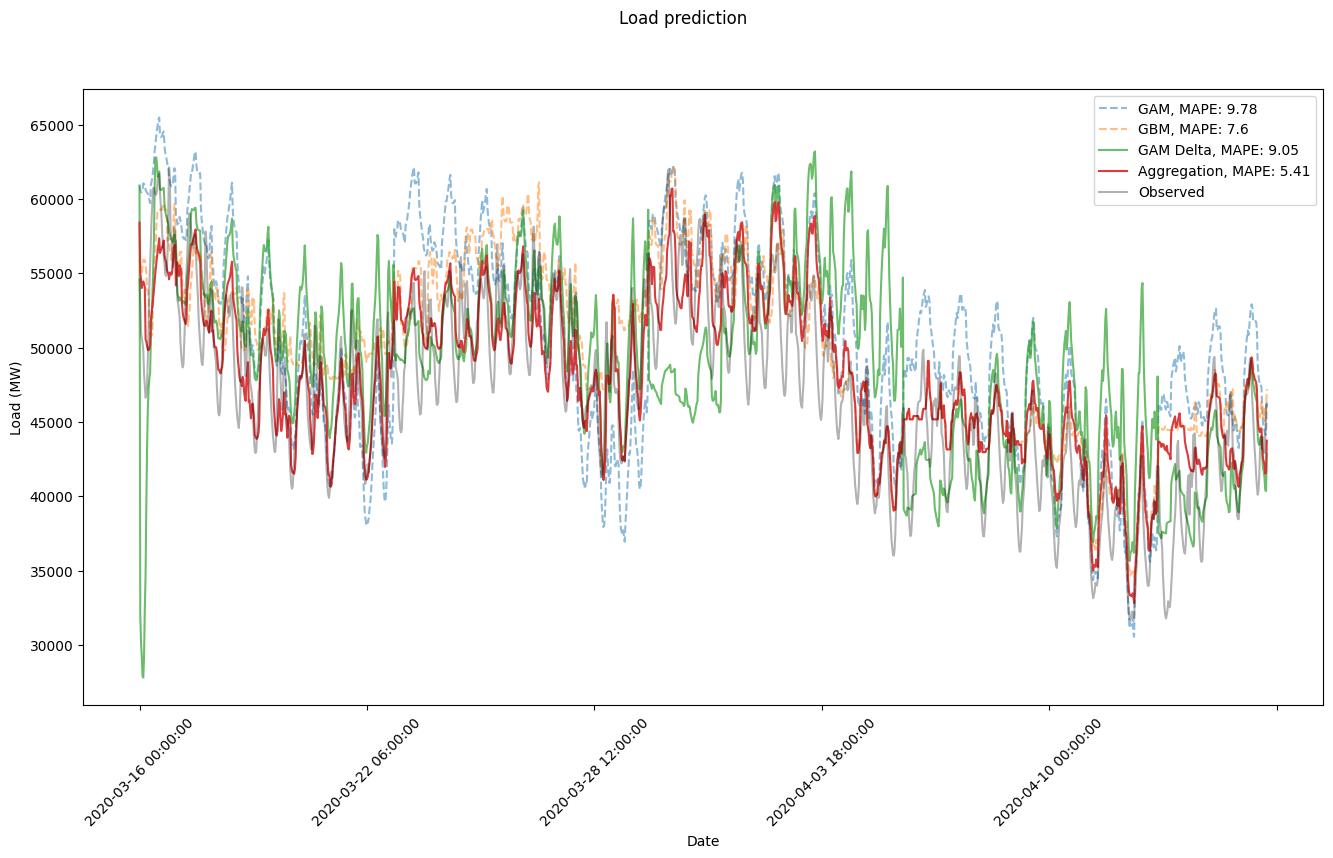

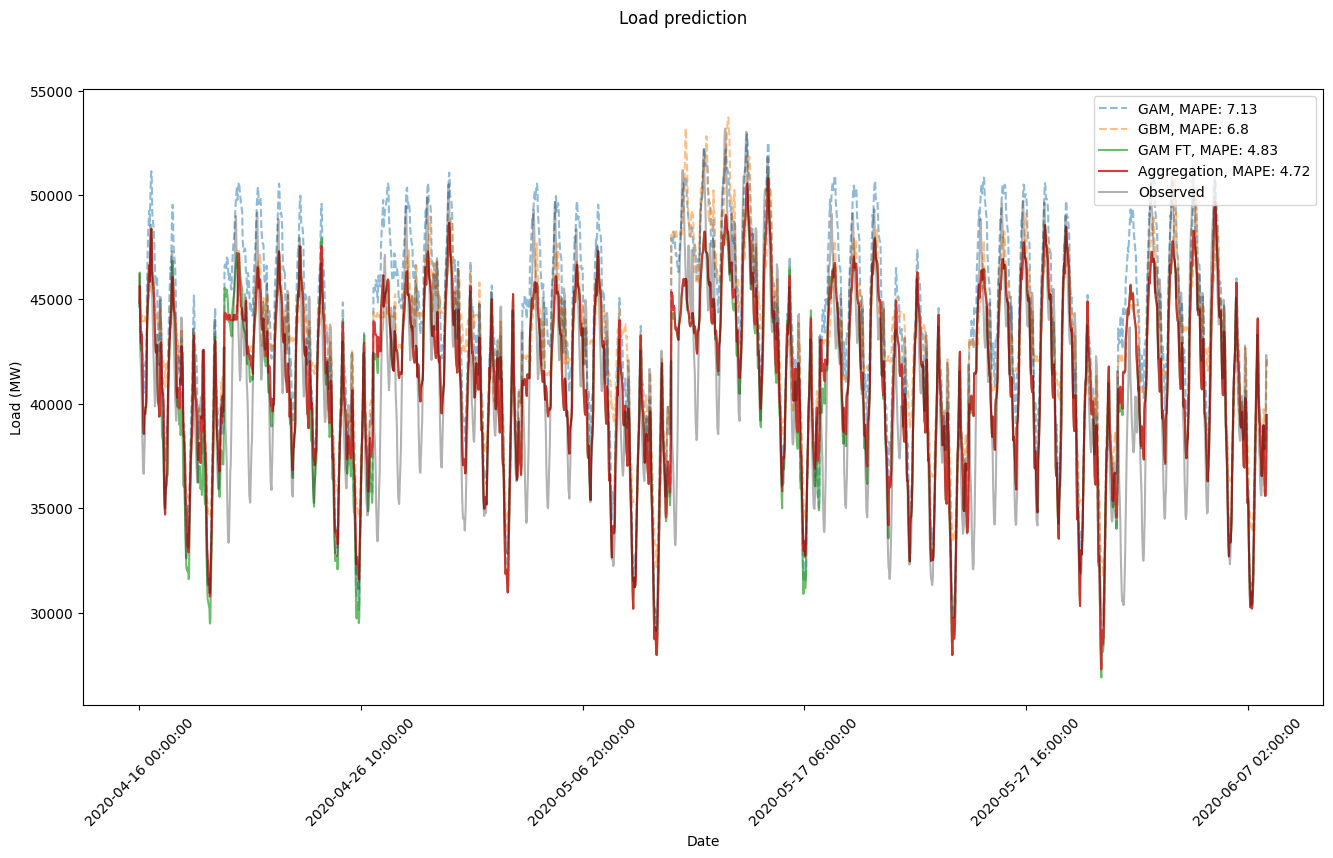

In [14]:
display_plots(type='test1', method='delta')
display_plots(type='test2', method='ft')

In [15]:
# Export the results to csv
ft_te1_df = pd.DataFrame(ft_te1, columns=['ft_te1'])
ft_te1_df.to_csv('data/experts/ft_te1.csv', index=False)
ft_te2_df = pd.DataFrame(ft_te2, columns=['ft_te2'])
ft_te2_df.to_csv('data/experts/ft_te2.csv', index=False)